Epoch 1/10: 100%|█████████████████████████████████████████████████████████| 831/831 [05:46<00:00,  2.39it/s, loss=1.81]


Train Acc: 0.5606, Train Loss: 2.1958 | Val Acc: 0.8091, Val Loss: 1.2662
Saved Best Model!


Epoch 2/10: 100%|████████████████████████████████████████████████████████| 831/831 [10:13<00:00,  1.35it/s, loss=0.541]


Train Acc: 0.7732, Train Loss: 1.0986 | Val Acc: 0.8297, Val Loss: 0.8072
Saved Best Model!


Epoch 3/10: 100%|█████████████████████████████████████████████████████████| 831/831 [10:44<00:00,  1.29it/s, loss=1.27]


Train Acc: 0.8210, Train Loss: 0.7687 | Val Acc: 0.8603, Val Loss: 0.6261
Saved Best Model!


Epoch 4/10: 100%|████████████████████████████████████████████████████████| 831/831 [10:51<00:00,  1.28it/s, loss=0.506]


Train Acc: 0.8450, Train Loss: 0.6173 | Val Acc: 0.8782, Val Loss: 0.4969
Saved Best Model!


Epoch 5/10: 100%|████████████████████████████████████████████████████████| 831/831 [10:45<00:00,  1.29it/s, loss=0.671]


Train Acc: 0.8654, Train Loss: 0.5211 | Val Acc: 0.8921, Val Loss: 0.4427
Saved Best Model!


Epoch 6/10: 100%|████████████████████████████████████████████████████████| 831/831 [08:26<00:00,  1.64it/s, loss=0.199]


Train Acc: 0.8797, Train Loss: 0.4604 | Val Acc: 0.9017, Val Loss: 0.3847
Saved Best Model!


Epoch 7/10: 100%|████████████████████████████████████████████████████████| 831/831 [05:29<00:00,  2.52it/s, loss=0.349]


Train Acc: 0.8889, Train Loss: 0.4122 | Val Acc: 0.9048, Val Loss: 0.3525
Saved Best Model!


Epoch 8/10: 100%|████████████████████████████████████████████████████████| 831/831 [05:21<00:00,  2.59it/s, loss=0.263]


Train Acc: 0.8934, Train Loss: 0.3855 | Val Acc: 0.9126, Val Loss: 0.3206
Saved Best Model!


Epoch 9/10: 100%|████████████████████████████████████████████████████████| 831/831 [05:24<00:00,  2.56it/s, loss=0.813]


Train Acc: 0.9023, Train Loss: 0.3545 | Val Acc: 0.9164, Val Loss: 0.2923
Saved Best Model!


Epoch 10/10: 100%|███████████████████████████████████████████████████████| 831/831 [05:24<00:00,  2.56it/s, loss=0.341]


Train Acc: 0.9041, Train Loss: 0.3359 | Val Acc: 0.9284, Val Loss: 0.2619
Saved Best Model!

🔧 Fine-tuning ResNet layers...
[FineTune] Epoch 1/5
Train Acc: 0.9365
Val   Acc: 0.9603
--------------------------------------------------
[FineTune] Epoch 2/5
Train Acc: 0.9539
Val   Acc: 0.9727
--------------------------------------------------
[FineTune] Epoch 3/5
Train Acc: 0.9645
Val   Acc: 0.9776
--------------------------------------------------
[FineTune] Epoch 4/5
Train Acc: 0.9706
Val   Acc: 0.9815
--------------------------------------------------
[FineTune] Epoch 5/5
Train Acc: 0.9766
Val   Acc: 0.9829
--------------------------------------------------

✅ Test Accuracy: 0.9850707176532216

📊 Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00        63
                                 Apple___Black_rot       0.98      1.00      0.99      

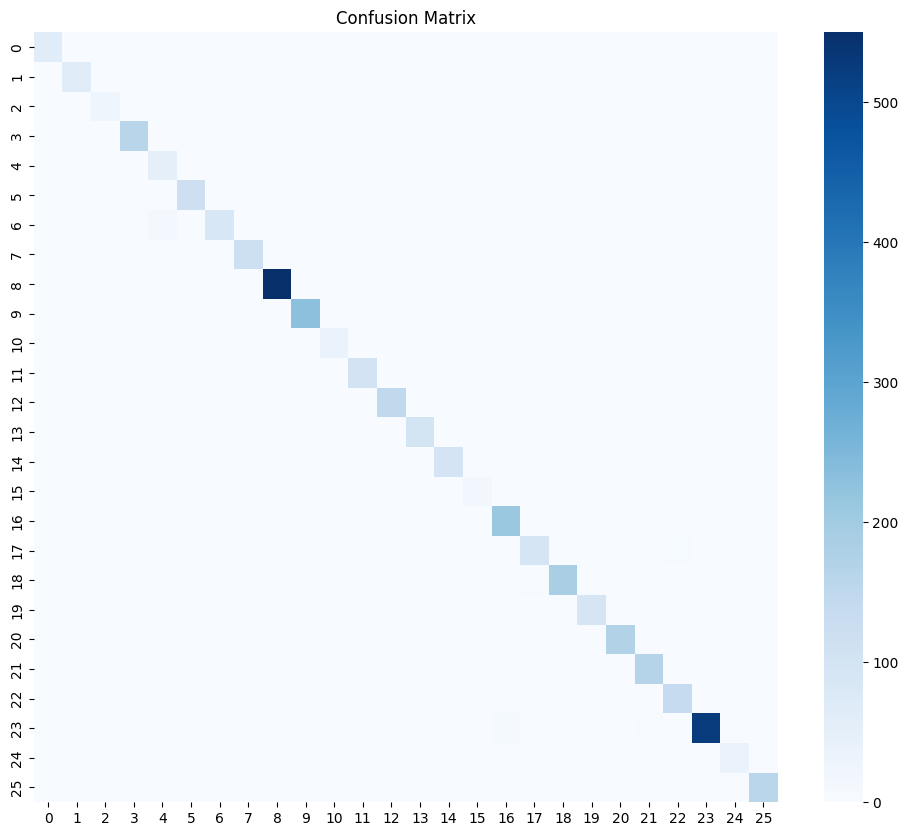

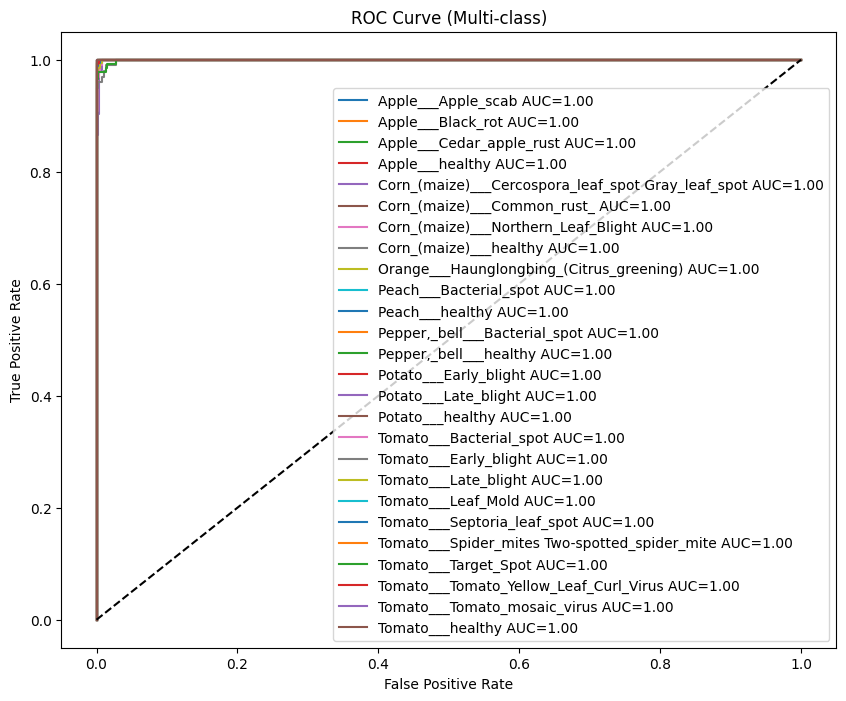

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# ================= CONFIG =================
DATA_DIR = r"dataset_split"   
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 10
NUM_CLASSES = 26
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ================= TRANSFORMS =================
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# ================= DATASETS =================
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes

# ================= CLASS WEIGHTS (IMBALANCE) =================
class_counts = np.bincount(train_dataset.targets)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# ================= LOAD RESNET50 =================
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)


# Freeze backbone (Transfer Learning)
for param in model.parameters():
    param.requires_grad = False

# Replace last layer
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, NUM_CLASSES)
)

model = model.to(DEVICE)

# ================= LOSS & OPTIMIZER =================
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

# ================= TRAINING LOOP =================
def train_one_epoch(model, loader):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total


def eval_model(model, loader):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = torch.argmax(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return running_loss / len(loader), correct / total, all_labels, all_preds


# ================= TRAIN =================
from tqdm import tqdm

best_val_acc = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss, correct, total = 0, 0, 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")

    for images, labels in train_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    val_loss, val_acc, _, _ = eval_model(model, val_loader)

    print(
        f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}"
    )

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved Best Model!")


# ================= FINE TUNING =================
print("\n🔧 Fine-tuning ResNet layers...")

for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-5)

for epoch in range(5):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc, _, _ = eval_model(model, val_loader)

    print(f"[FineTune] Epoch {epoch+1}/5")
    print(f"Train Acc: {train_acc:.4f}")
    print(f"Val   Acc: {val_acc:.4f}")
    print("-" * 50)

# ================= TEST EVALUATION =================
test_loss, test_acc, y_true, y_pred = eval_model(model, test_loader)

print("\n✅ Test Accuracy:", test_acc)

# ================= CLASSIFICATION REPORT =================
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# ================= CONFUSION MATRIX =================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ================= ROC CURVE =================
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
y_pred_prob = []

model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        y_pred_prob.extend(probs.cpu().numpy())

y_pred_prob = np.array(y_pred_prob)

fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(10,8))
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} AUC={roc_auc[i]:.2f}")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve (Multi-class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [2]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, class_names, device="cuda"):
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [4]:
y_true, y_pred, y_prob = evaluate_model(model, test_loader, class_names)

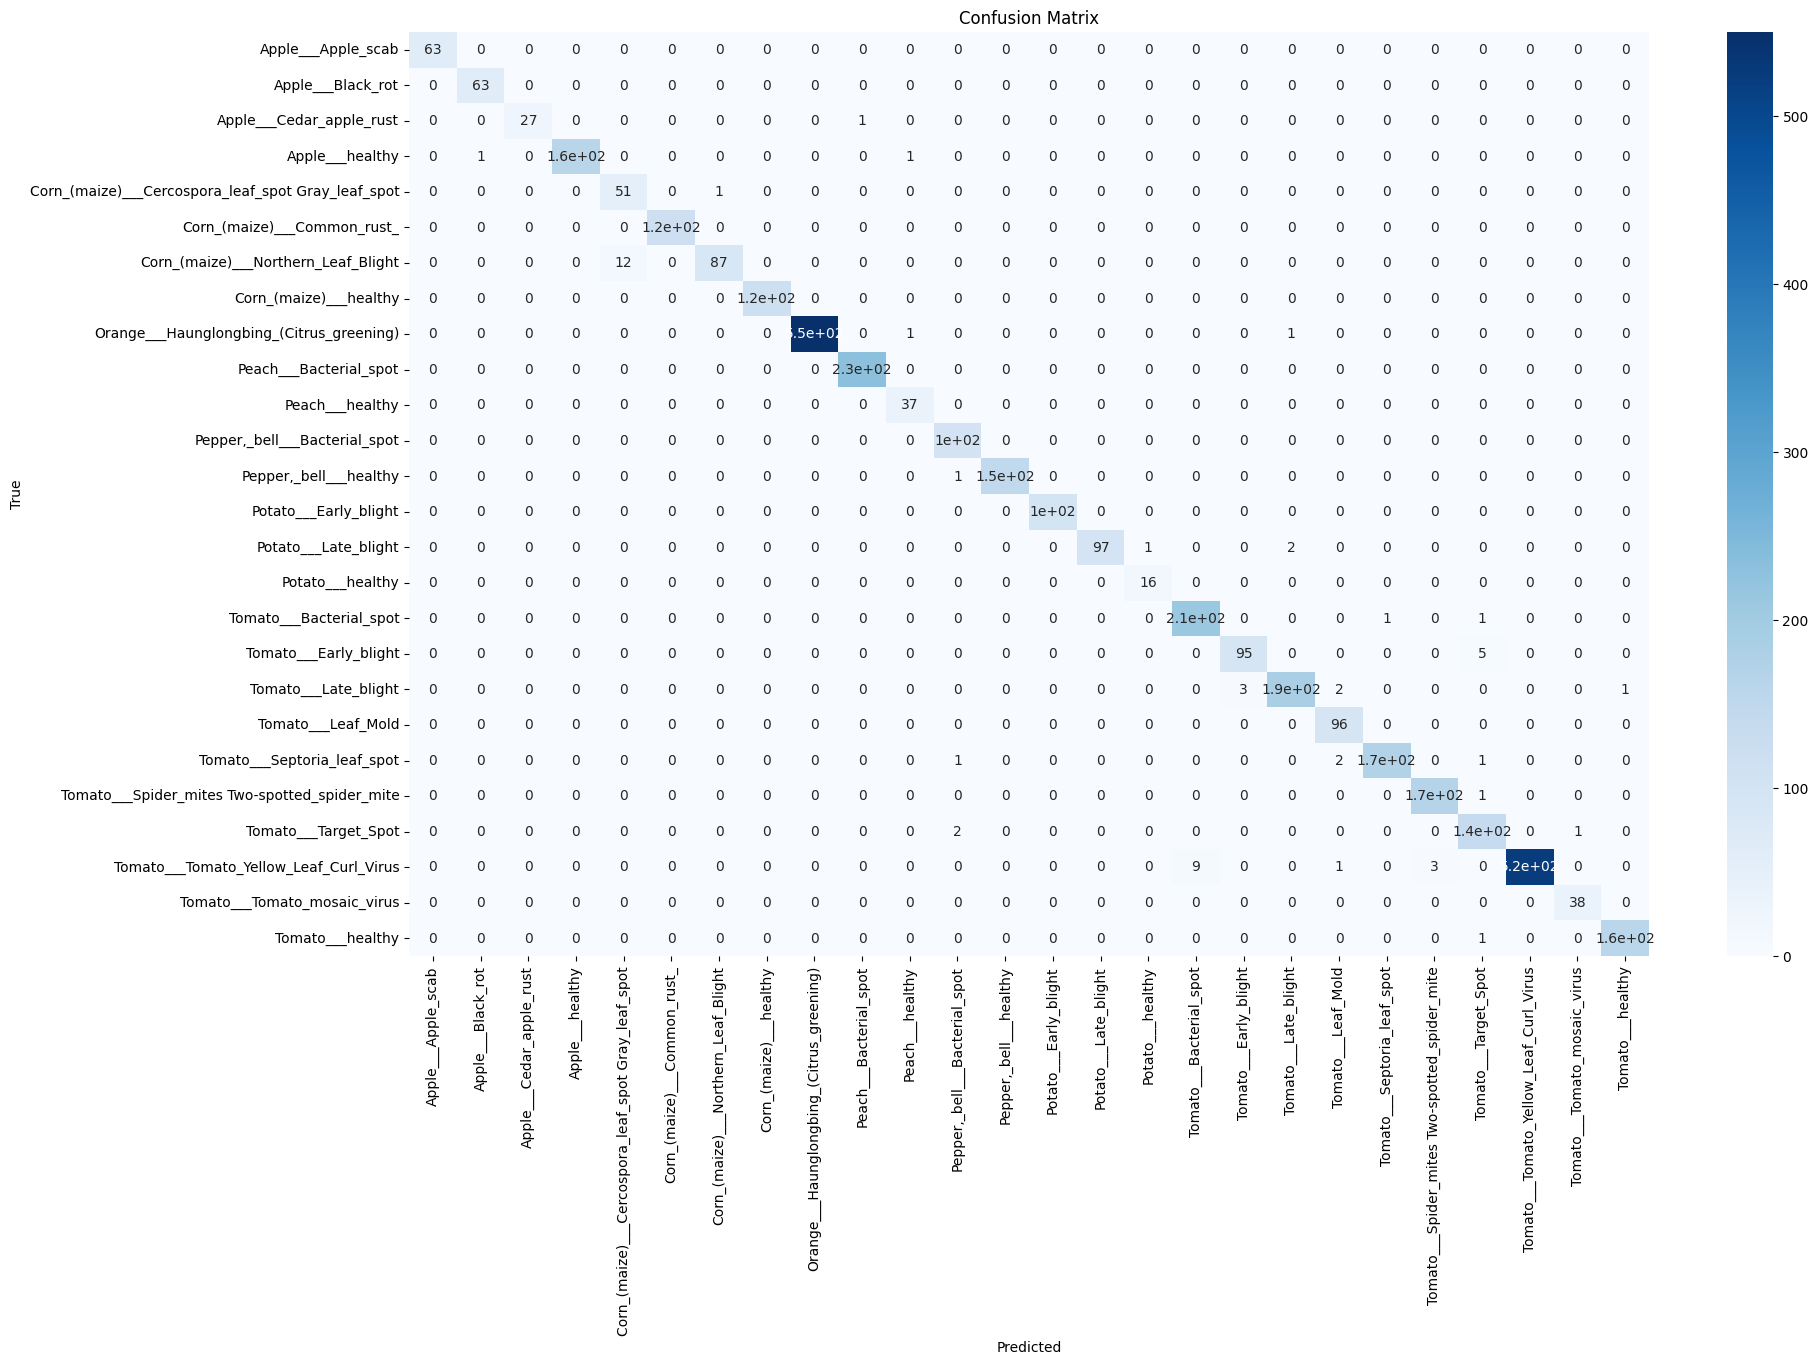

In [8]:
class_names = train_dataset.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 12))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
sns.heatmap(cm, annot=True,  cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


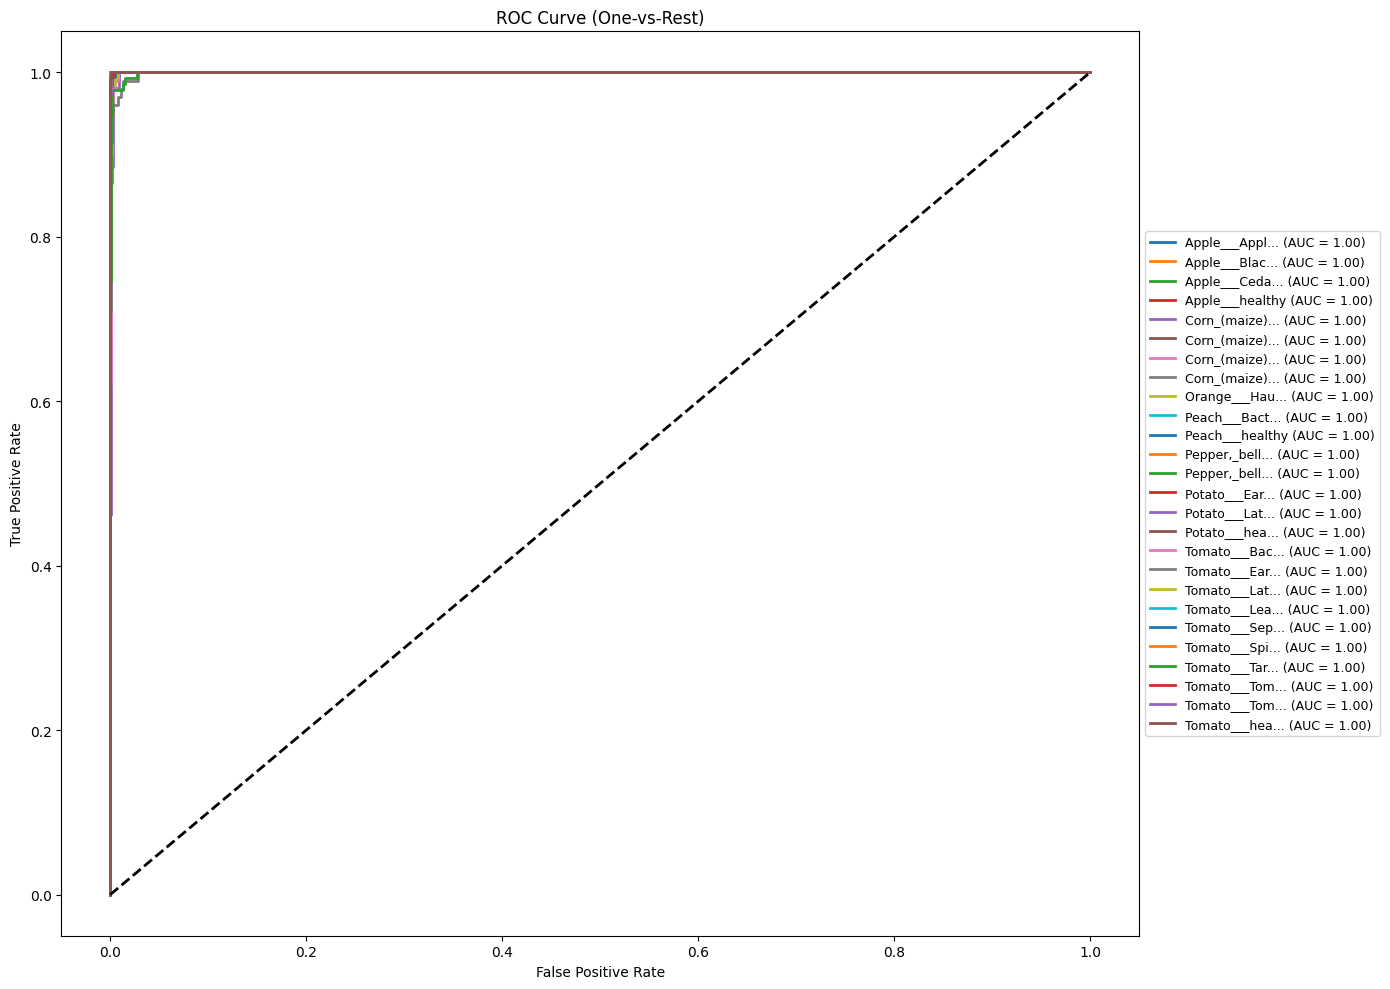

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
n_classes = y_true_bin.shape[1]

plt.figure(figsize=(14, 10))  

short_names = [name if len(name) <= 15 else name[:12]+"..." for name in class_names]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    auc_score = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f"{short_names[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.tight_layout()
plt.show()


In [9]:
torch.save(model.state_dict(), "best_model_finetuned.pth")
print("Fine-tuned model saved!")


Fine-tuned model saved!
